In [34]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pickle

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [9]:
DATA_PATH = '../data/processed'
MODEL_PATH = '../models'

## Loading data from file

In [4]:
def load_data(year, img_h=1400, img_w=1400):

    X = []
    y = []

    data_dir = os.path.join(DATA_PATH, str(year))
    frames_dir = os.path.join(data_dir, 'frames')
    masks_dir = os.path.join(data_dir, 'masks')

    for file in sorted(os.listdir(frames_dir)):
        if file.startswith('R'):
            filename = file.split('.')[0]

            frame = np.load(os.path.join(frames_dir, filename + '.npy'))
            mask = np.load(os.path.join(masks_dir, filename + '_labels.npy'))
            X.append(frame[:img_h, :img_w, :])
            y.append(mask[:img_h, :img_w])

    X = np.array(X)
    y = np.array(y)

    return X, y

## Data preprocessing

In [5]:
def reshape_data(X, y):
    """ Reshapes data so that columns are spectral bands and rows are pixels """

    X_reshaped = X.reshape(-1, X.shape[-1])
    y_reshaped = y.reshape(-1)

    return X_reshaped, y_reshaped

def standardizer(X):
    """ Standardizes features by removing mean and scaling to unit variance  """
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled

## Building model pipeline

In [6]:
def build_pipeline():
    """ Builds logistic regression pipeline with standardization """
    
    pipeline = Pipeline([
        ('standarize', FunctionTransformer(standardizer, validate=False)),
        ('log_reg', LogisticRegression(solver='lbfgs', max_iter=300))])

    return pipeline


def save_model(pipeline, filename):
    model = pipeline.named_steps['log_reg']
    pickle.dump(model, open(os.path.join(MODEL_PATH, filename), 'wb'))

    
def load_model(filename):
    """ Loads trained model from file  """

    with open(os.path.join(MODEL_PATH, filename), 'rb') as file:
        pickle_model = pickle.load(file)
        
    return pickle_model

## Visualization

In [215]:
def plot_image(image, factor=1):
    """ Plot RGB spectral bands """    
    
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)
        
def plot_labels(labels):
    """ Plot corn labels """
    
    plt.imshow(labels, cmap='viridis')
    
def plot_labels_overlay(image, labels):
    """ Plot satellite image with corn labels """
    
    y_ = labels.astype('float')
    y_[y_==0] = np.nan

    plot_image(image, 7)
    plt.imshow(y_, cmap='viridis_r')
    
def plot_all(image, y_true, y_pred, size=500, figsize=(20,10)):
    
    f = plt.figure(figsize=figsize)

    plt.subplot(141)
    plt.title('Original')
    plt.xticks([])
    plt.yticks([])
    plot_image(image[:size,:size,[3,2,1]], 7)

    plt.subplot(142)
    plt.title('Ground Truth')
    plt.xticks([])
    plt.yticks([])
    plot_labels(y_true[:size,:size])

    if y_pred.size:
        plt.subplot(143)
        plt.title('Prediction')
        plt.xticks([])
        plt.yticks([])
        plot_labels(y_pred[:size,:size])

        plt.subplot(144)
        plt.title('Overlay')
        plt.xticks([])
        plt.yticks([])
        plot_labels_overlay(image[:size,:size,[3,2,1]], y_pred[:size,:size])

## Metrics

In [7]:
def intersection_over_union(confusion_matrix):
    """ Intersection-over-union metric for image segmentation """
    
    tn, fp, fn, tp = confusion_matrix.ravel()
    iou = tp / (tp + fn + fp)
    return iou

def print_metrics(y_true, y_pred):
    """ Print classification metrics  """
    
    conf_mat = confusion_matrix(y_true, y_pred)

    print('Accuracy: %.2f' % accuracy_score(y_true, y_pred))
    print('Intersection-over-Union: %.2f' % intersection_over_union(conf_mat))
    print('Confusion Matrix: \n', conf_mat)
    print('Classification report:\n', classification_report(y_true, y_pred))

## Training on 2017 data 

### Loading 2017 data

In [213]:
X, y = load_data(year=2017)

### Visualizing data sample

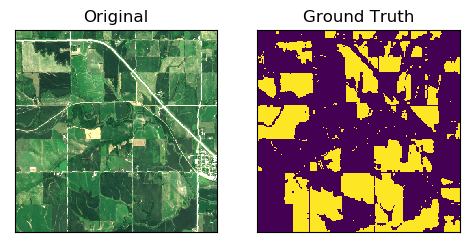

In [219]:
plot_all(X[0], y[0], y_pred="", size=500, figsize=(12,7))

### Reshaping data

In [220]:
print("X shape: (%d images, %d px height, %d px width, %d channels)" 
      % (X.shape[0], X.shape[1], X.shape[2], X.shape[3]))

print("y shape: (%d masks, %d px height, %d px width)\n" 
      % (y.shape[0], y.shape[1], y.shape[2]))

# reshape data so that columns are spectral bands and rows are pixels
X, y = reshape_data(X, y)

print("X reshaped: (%d pixels, %d channels)" 
      % (X.shape[0], X.shape[1]))

print("y reshaped: (%d pixels)" 
      % (y.shape[0]))

X shape: (30 images, 1400 px height, 1400 px width, 13 channels)
y shape: (30 masks, 1400 px height, 1400 px width)

X reshaped: (58800000 pixels, 13 channels)
y reshaped: (58800000 pixels)


### Training logistic regression

In [ ]:
# train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)

# training
log_reg_pipeline = build_pipeline()
log_reg_pipeline.fit(X_train, y_train)

# save model
save_model(log_reg_pipeline, 'log_reg.pkl')

### Validation set results

In [36]:
# predicting
y_pred = log_reg_pipeline.predict(X_val)

# results
print_metrics(y_val, y_pred)

Accuracy: 0.92
Intersection-over-Union: 0.77
Confusion Matrix: 
 [[7797563  323234]
 [ 580192 3059011]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95   8120797
           1       0.90      0.84      0.87   3639203

    accuracy                           0.92  11760000
   macro avg       0.92      0.90      0.91  11760000
weighted avg       0.92      0.92      0.92  11760000



## Testing on 2018 data

In [191]:
# load data
X, y = load_data(year=2018)
X_shape, y_shape = X.shape, y.shape

# loading trained model
log_reg = load_model('log_reg.pkl')

# preprocessing
X, y = reshape_data(X, y)
X_scaled = standardizer(X)

# making predictions
y_pred = log_reg.predict(X_scaled)

### Test results

In [192]:
print_metrics(y, y_pred)

Accuracy: 0.91
Intersection-over-Union: 0.72
Confusion Matrix: 
 [[29965415  2062306]
 [ 2153852 10898427]]
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93  32027721
           1       0.84      0.83      0.84  13052279

    accuracy                           0.91  45080000
   macro avg       0.89      0.89      0.89  45080000
weighted avg       0.91      0.91      0.91  45080000



### Visualizing results

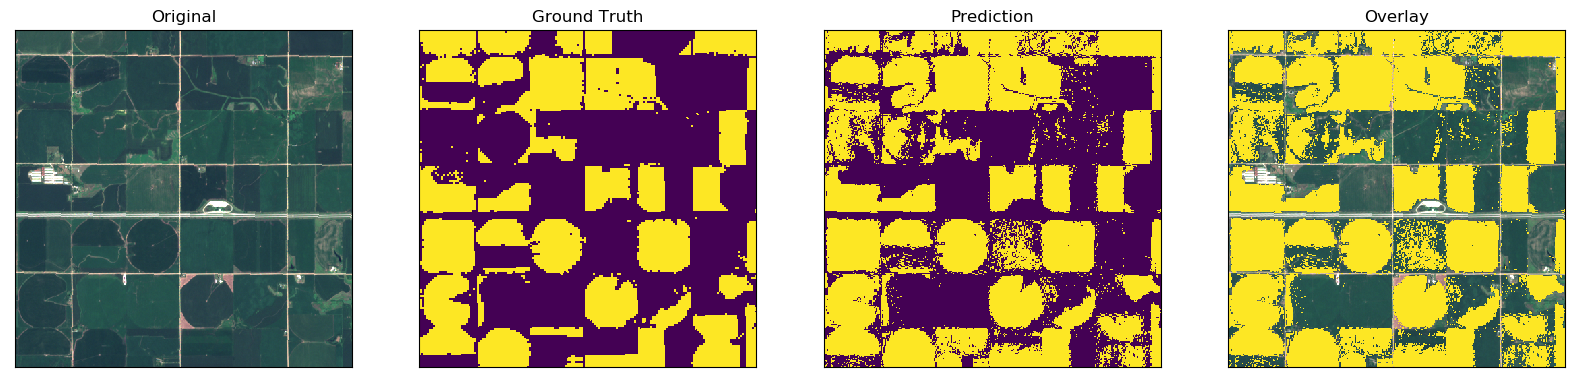

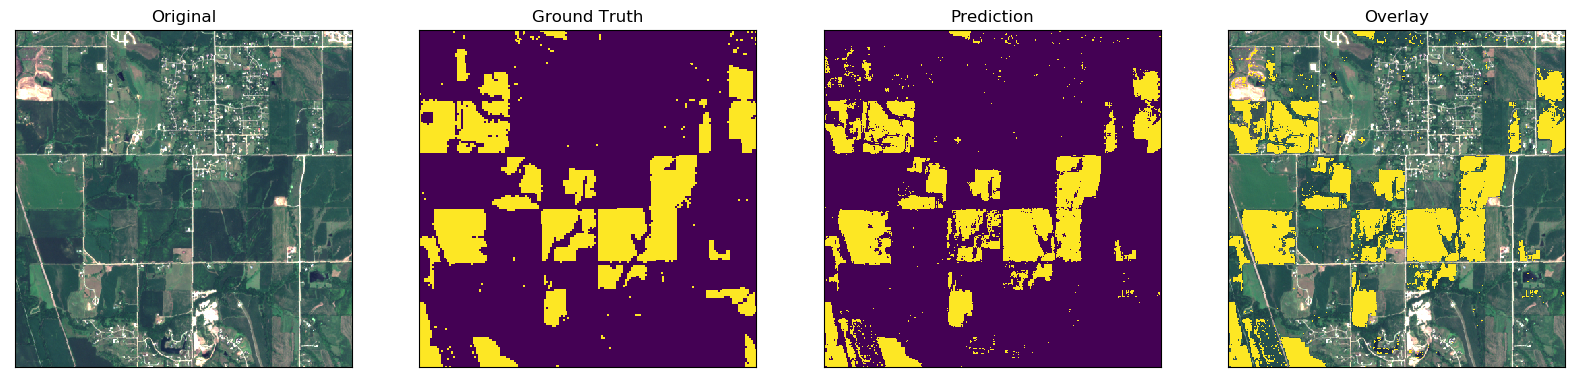

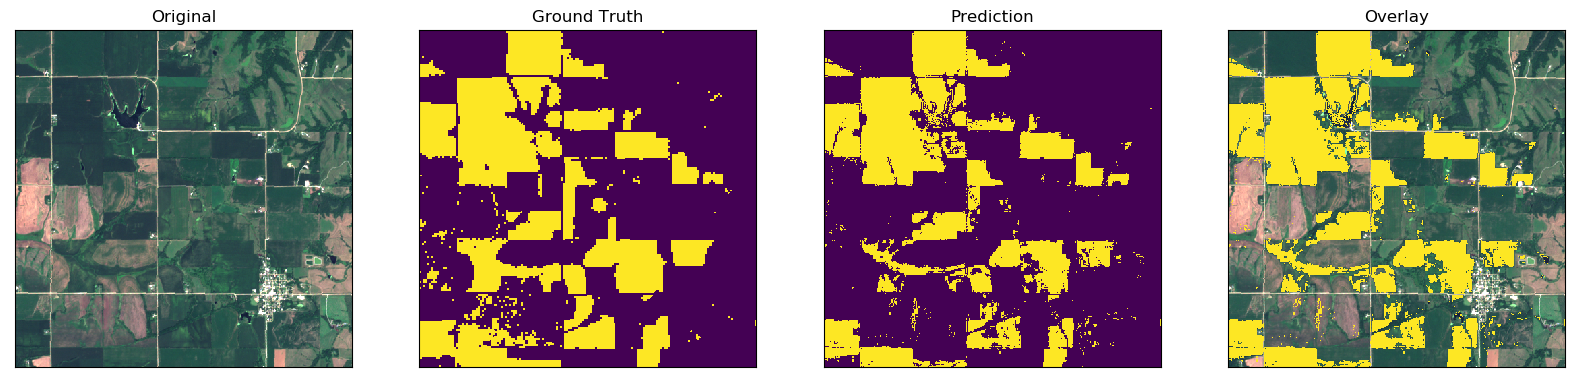

In [202]:
X = X.reshape(X_shape)

y_pred = y_pred.reshape(y_shape)
y = y.reshape(y_shape)

for i in range(3):
    idx = np.random.randint(0,23)
    plot_all(X[idx], y[idx], y_pred[idx])